# Seminar Deep Learning - Stochastic Gradient Descent

*Hochschule Offenburg*

*Dennis Bystrow, INFM-3*

## Overview

1. Introduction to SGD
- Overview and implementations of a few SGD optimizations
  1. Basic PyTorch implementation
    1. The CIFAR10 Dataset
  - SGD
    1. Mini-Batch
    - SGD with Momentum
    - SGD with learning rate schedule
  - AdaGrad
  - RMSProp
- Results
  - SGD
    1. Mini-Batch
    - SGD with Momentum
    - SGD with learning rate schedule
  - AdaGrad
  - RMSProp
- Sources


## 1. Introduction to SGD

## 2. Overview and implementations of a few SGD optimizations

### Basic PyTorch implementation

#### The CIFAR10 dataset

The dataset CIFAR10 https://www.cs.toronto.edu/~kriz/cifar.html will be used

The CIFAR10 dataset is included in the torchvision library. It will can therefore be easily loaded and accessed via code only: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#loading-and-normalizing-cifar10

An existing, untrained resnet20 implementation from https://github.com/cc-hpc-itwm/GradVis/blob/master/Examples/resnet20_example.py will be used

In [19]:
%load_ext autoreload
%autoreload 2

In [22]:
import pandas as pd

from main import main
from create_visualizations import create_plots_from_checkpoints, TrainVisCIFAR10
from gradvis import resnets

Run learning

In [2]:
main()

running on device: cuda
Files already downloaded and verified
Files already downloaded and verified
directory ./checkpoints\wip_cifar_resnet_sgd was created
Epoch: [1/20]


  : 100%|██████████| 196/196 [00:17<00:00, 11.17it/s]


  Train Avg Loss: 1.8293 Acc: 0.3076
  testing...
  Test Avg Loss: 1.7680 Acc: 0.3449
Epoch: [2/20]


  : 100%|██████████| 196/196 [00:13<00:00, 15.12it/s]


  Train Avg Loss: 1.5154 Acc: 0.4281
  testing...
  Test Avg Loss: 1.6889 Acc: 0.3957
Epoch: [3/20]


  : 100%|██████████| 196/196 [00:13<00:00, 15.16it/s]


  Train Avg Loss: 1.3446 Acc: 0.5032
  testing...
  Test Avg Loss: 1.4196 Acc: 0.4819
Epoch: [4/20]


  : 100%|██████████| 196/196 [00:13<00:00, 14.95it/s]


  Train Avg Loss: 1.2264 Acc: 0.5491
  testing...
  Test Avg Loss: 1.3024 Acc: 0.5299
Epoch: [5/20]


  : 100%|██████████| 196/196 [00:13<00:00, 14.96it/s]


  Train Avg Loss: 1.1329 Acc: 0.5860
  testing...
  Test Avg Loss: 1.1937 Acc: 0.5657
Epoch: [6/20]


  : 100%|██████████| 196/196 [00:13<00:00, 15.07it/s]


  Train Avg Loss: 1.0553 Acc: 0.6164
  testing...
  Test Avg Loss: 1.3713 Acc: 0.5219
Epoch: [7/20]


  : 100%|██████████| 196/196 [00:13<00:00, 15.13it/s]


  Train Avg Loss: 0.9898 Acc: 0.6398
  testing...
  Test Avg Loss: 1.0365 Acc: 0.6301
Epoch: [8/20]


  : 100%|██████████| 196/196 [00:13<00:00, 15.11it/s]


  Train Avg Loss: 0.9324 Acc: 0.6630
  testing...
  Test Avg Loss: 1.8831 Acc: 0.4397
Epoch: [9/20]


  : 100%|██████████| 196/196 [00:13<00:00, 15.09it/s]


  Train Avg Loss: 0.8779 Acc: 0.6847
  testing...
  Test Avg Loss: 1.1731 Acc: 0.5941
Epoch: [10/20]


  : 100%|██████████| 196/196 [00:13<00:00, 15.07it/s]


  Train Avg Loss: 0.8366 Acc: 0.6991
  testing...
  Test Avg Loss: 1.3420 Acc: 0.5602
Epoch: [11/20]


  : 100%|██████████| 196/196 [00:13<00:00, 15.11it/s]


  Train Avg Loss: 0.7975 Acc: 0.7140
  testing...
  Test Avg Loss: 1.0503 Acc: 0.6330
Epoch: [12/20]


  : 100%|██████████| 196/196 [00:13<00:00, 15.10it/s]


  Train Avg Loss: 0.7561 Acc: 0.7287
  testing...
  Test Avg Loss: 1.4712 Acc: 0.5538
Epoch: [13/20]


  : 100%|██████████| 196/196 [00:13<00:00, 15.01it/s]


  Train Avg Loss: 0.7200 Acc: 0.7426
  testing...
  Test Avg Loss: 1.1825 Acc: 0.6094
Epoch: [14/20]


  : 100%|██████████| 196/196 [00:13<00:00, 14.99it/s]


  Train Avg Loss: 0.6860 Acc: 0.7568
  testing...
  Test Avg Loss: 1.4862 Acc: 0.5617
Epoch: [15/20]


  : 100%|██████████| 196/196 [00:13<00:00, 14.96it/s]


  Train Avg Loss: 0.6492 Acc: 0.7703
  testing...
  Test Avg Loss: 1.7807 Acc: 0.5131
Epoch: [16/20]


  : 100%|██████████| 196/196 [00:13<00:00, 15.22it/s]


  Train Avg Loss: 0.6161 Acc: 0.7816
  testing...
  Test Avg Loss: 1.8965 Acc: 0.4764
Epoch: [17/20]


  : 100%|██████████| 196/196 [00:13<00:00, 14.88it/s]


  Train Avg Loss: 0.5803 Acc: 0.7946
  testing...
  Test Avg Loss: 1.2119 Acc: 0.6265
Epoch: [18/20]


  : 100%|██████████| 196/196 [00:13<00:00, 15.10it/s]


  Train Avg Loss: 0.5506 Acc: 0.8050
  testing...
  Test Avg Loss: 1.4147 Acc: 0.5994
Epoch: [19/20]


  : 100%|██████████| 196/196 [00:13<00:00, 14.89it/s]


  Train Avg Loss: 0.5167 Acc: 0.8186
  testing...
  Test Avg Loss: 1.6466 Acc: 0.5324
Epoch: [20/20]


  : 100%|██████████| 196/196 [00:13<00:00, 14.93it/s]


  Train Avg Loss: 0.4889 Acc: 0.8284
  testing...
  Test Avg Loss: 1.4284 Acc: 0.6103
Training took 320.97 seconds


Create visualizations from checkpoints

In [21]:
bare_model = resnets.resnet20_cifar()
train_vis_function = TrainVisCIFAR10(
    "./cifar_data").get_train_vis_function()
create_plots_from_checkpoints(bare_model,
                              train_vis_function,
                              "./checkpoints/wip_cifar_resnet_sgd",
                              "wip_cifar_resnet_sgd",
                              "./visualizations/wip_cifar_resnet_sgd",
                              "wip_cifar_resnet_sgd",
                              amount=-1,
                              loss_3D_degrees=120)

Files already downloaded and verified
directory ./visualizations/wip_cifar_resnet_sgd was created
Calculating PCA directions...
Principal [0.69083024 0.24714668]
Normalizing...
Calculating coefficients...
Calculating Z-values of paths...


100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Calculating loss landscape...


100%|██████████| 21/21 [08:50<00:00, 25.10s/it]


Saving figure ./visualizations/wip_cifar_resnet_sgd\wip_cifar_resnet_sgd_2D_plot_pca_20.svg
Saving figure ./visualizations/wip_cifar_resnet_sgd\wip_cifar_resnet_sgd_3D_plot_pca_20.svg


Show resulting visualizations

2D plot of loss surface and path for this experiment

TODO: Does this look weird, because I messed around too much with gradvis or because the resulting path is actually weird?

![This should be an image](visualizations/wip_cifar_resnet_sgd/wip_cifar_resnet_sgd_2D_plot_pca_20.svg "2D Plot of loss surface and path for this experiment")

3D plot of loss surface and path for this experiment

![This should be an image](visualizations/wip_cifar_resnet_sgd/wip_cifar_resnet_sgd_3D_plot_pca_20.svg "3D Plot of loss surface and path for this experiment")

Create diagram from loss and accuracy

In [32]:
experiment_stats = pd.read_csv("experiments_stats/wip_cifar_resnet_sgd.csv")
experiment_stats.head(2)

,experiment_title,epoch,epoch_amount,train_avg_loss,train_acc,test_avg_loss,test_acc,timestamp
0,wip_cifar_resnet_sgd,1,20,1.829314,0.30760,1.767976,0.3449,2019-11-27 17:26:51.678000
1,wip_cifar_resnet_sgd,2,20,1.515386,0.42814,1.688947,0.3957,2019-11-27 17:27:07.592042


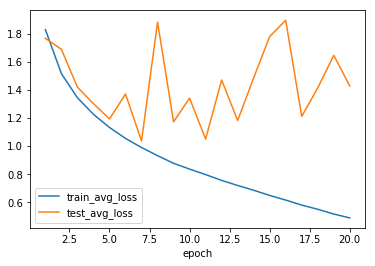

In [30]:
experiment_stats.plot(x="epoch", y=["train_avg_loss", "test_avg_loss"])

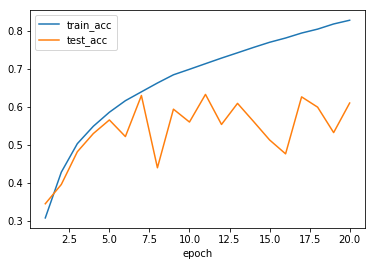

In [31]:
experiment_stats.plot(x="epoch", y=["train_acc", "test_acc"])